In [25]:


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import pickle
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.random_projection import GaussianRandomProjection
from scipy import stats
from scipy.stats import zscore, norm, spearmanr
import pingouin
from scipy.optimize import curve_fit
import sympy as sp
from joblib import Parallel, delayed
import numpy as np
from decode_utils import get_percent_correct_from_proba
warnings.filterwarnings('ignore')

def save(x, filename):
    pickle.dump(x, open(f'{filename}.pkl', 'wb'))
def load(filename):
    pd.read_pickle(filename)



lb = ['bear', 'elephant', 'person', 'car', 'dog', 'apple', 'chair', 'plane', 'bird', 'zebra']
labels = np.repeat(lb, 60, axis=0)


NB_CONTEXT_TYPES = 10
NB_OBJECT_TYPES = 10
NB_IMAGES = 600
seeds=[0, 6, 28, 42, 77, 94, 127, 255, 546, 612]




In [91]:
def subsample_trials(trials, num_trials_increase):
    all_trials=dict()
    list_index= list(range(trials.shape[1]))
    num_trials=trials.shape[1]
    for nb_trials_to_take in num_trials_increase:
        
        all_trials_seed=[]
        for shuffle_seed in seeds:
            unq_seed=hash((nb_trials_to_take, shuffle_seed)) & ((1 << 32) - 1)
            np.random.seed(unq_seed)
            shuffled_list=np.random.permutation(list_index)
            all_trials_seed.append(trials[:,shuffled_list[:nb_trials_to_take]])
        all_trials[nb_trials_to_take] = np.array(all_trials_seed)
    return all_trials

def get_splithalf_corr(data, num_seeds=10, decode_=False, nb_trials_subsample=None, img_subsample=list(range(600))):
    # Calculate split-half correlation for 100 seeds
    num_neurons=data.shape[2]
    print(f'number of neurons {num_neurons}, number of images: {data.shape[0]}, number of trials: {data.shape[1]}')
    split_half_correlation = { 'I1': np.zeros((num_seeds,num_neurons)),
                               'C1': np.zeros((num_seeds,num_neurons)),
                             'I1_decode': np.zeros((num_seeds,num_neurons)),
                             'C1_decode': np.zeros((num_seeds,num_neurons))}
    nb_trials = data.shape[1]
    subsample_trials=data.shape[1]//2 if nb_trials_subsample==None else nb_trials_subsample//2
    splits=iter(np.array([
    [
        np.random.seed(seed), 
        np.random.permutation(nb_trials)[0:subsample_trials],
        np.random.seed(seed),
        np.random.permutation(nb_trials)[subsample_trials:2*subsample_trials]
    ][1::2] for seed in range(num_seeds)]).reshape((num_seeds*2, subsample_trials)) )
    for i in range(num_seeds):
        
        sh1, sh2 = data[:,next(splits)].mean(axis=1), data[:,next(splits)].mean(axis=1)
        
        i1_corr_values = [ spearmanr(sh1[:,  j], sh2[:, j])[0] for j in range(num_neurons)]
        
        i1_shc=np.array(i1_corr_values)
        i1_shc=(2*i1_shc)/(1+i1_shc)
        split_half_correlation['I1'][i] = i1_shc
        if decode_:
            _,p_sh1= decode(sh1.T, labels,nrfolds=5, seed=i )
            _,p_sh2= decode(sh2.T, labels,nrfolds=5, seed=i )
            pc_sh1=get_percent_correct_from_proba(p_sh1,labels)
            pc_sh2=get_percent_correct_from_proba(p_sh2,labels)
            print(pc_sh1.shape,  pc_sh2.shape)
            i1_pred_shc = np.corrcoef(np.nanmean(pc_sh1, axis=1)[img_subsample], np.nanmean(pc_sh2, axis=1)[img_subsample])[0,1]
            #print(i1_pred_shc)
            i1_pred_shc = (2*i1_pred_shc)/(1+i1_pred_shc)
            c1_pred_shc = np.corrcoef([np.nanmean(pc_sh1, axis=1)[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)],
                                      [np.nanmean(pc_sh2, axis=1)[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])[0,1]

            c1_pred_shc = (2*c1_pred_shc)/(1+c1_pred_shc)
            split_half_correlation['I1_decode'][i] = i1_pred_shc
            split_half_correlation['C1_decode'][i] = c1_pred_shc
        c1_sh1 = np.array([sh1[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])
        c1_sh2 = np.array([sh2[k::NB_CONTEXT_TYPES].mean(axis=0) for k in range(NB_CONTEXT_TYPES)])
        c1_corr_values = [ spearmanr(c1_sh1[:, j], c1_sh2[:, j])[0] for j in range(num_neurons)]
        
        c1_shc=np.array(c1_corr_values)
        c1_shc=(2*c1_shc)/(1+c1_shc)
        split_half_correlation['C1'][i] = c1_shc 
        

    print(f"Average split-half correlation across {num_seeds} seeds I1: {np.nanmean(split_half_correlation['I1']):.4f} C1: {np.nanmean(split_half_correlation['C1']):.4f}")
    return split_half_correlation 

def get_consistency_no_subsampling(x, y, correct =True, sqrt=True):
    x = np.array(x) if isinstance(x, list) else x
    y = np.array(y) if isinstance(y, list) else y
    x, y = pd.Series(x.squeeze().flatten()), pd.Series(y.squeeze().flatten())
    
    cons = x.corr(y)
    
    if correct:
        cons= 2*cons/(1+cons)
    if sqrt:
        cons = np.sqrt(cons)
    return cons


def distribution_info(corr_coefs):
    #corr_coefs = list(sum(corr_coefs,()))
    return (np.nanmean(corr_coefs), np.nanstd(corr_coefs), np.nanmax(corr_coefs), np.nanmin(corr_coefs), corr_coefs)






In [6]:
pooled_rates_full=pd.read_pickle('data/pooled_rates_both.pkl.pkl')
print('pooled rates images x trials x bins x neurons', pooled_rates_full.shape)

pooled_rates_7_17=np.nanmean(pooled_rates_full[:,:,7:17,:], axis=2)
print('pooled rates 70-170 ms images x trials  x neurons', pooled_rates_7_17.shape)

pooled_rates_10_18=np.nanmean(pooled_rates_full[:,:,10:18,:], axis=2)


# Getting the most reliable rates based on 70-170 ms
shc= get_splithalf_corr(pooled_rates_7_17[:,:-1,:], num_seeds=100)

df_shc=pd.DataFrame(shc['I1'].T.mean(axis=1), columns=['I1'])
df_shc['C1']=shc['C1'].T.mean(axis=1)

pooled rates images x trials x bins x neurons (600, 31, 30, 222)
pooled rates 70-170 ms images x trials  x neurons (600, 31, 222)
number of neurons 222, number of images: 600, number of trials: 30
Average split-half correlation across 100 seeds I1: 0.2743 C1: 0.5355


In [7]:
reliable_rates=df_shc[df_shc['I1']>0.1].index
reliable_neurons_7_17=pooled_rates_7_17[:,:-1,reliable_rates]
reliable_neurons_10_18=pooled_rates_10_18[:,:-1,reliable_rates]
print('reliable pooled rates 70-170 ms images x trials  x neurons', reliable_neurons_7_17.shape)
print('reliable pooled rates 100-180 ms images x trials  x neurons', reliable_neurons_10_18.shape)

reliable pooled rates 70-170 ms images x trials  x neurons (600, 30, 122)
reliable pooled rates 100-180 ms images x trials  x neurons (600, 30, 122)


In [ ]:
#save(reliable_neurons_7_17, 'reliable_neurons_7_17')

In [11]:
from decode_utils import get_percent_correct_from_proba
from sklearn.model_selection import GroupKFold, StratifiedKFold, RepeatedKFold,LeavePGroupsOut, GroupShuffleSplit


def decode(features,labels,nrfolds=2,seed=0):

    
    classes=np.unique(labels)
    nrImages = features.shape[1]
    _,ind = np.unique(classes, return_inverse=True)   
    #scale data
    #features = zscore(features,axis=0)
    #X_scaled = scaler.fit_transform(X)
    #features = scale(features.T).T
    num_classes = len(classes)
    prob = np.zeros((nrImages,len(classes)))
    prob[:]=np.NAN
    actual_pred=np.zeros(nrImages)
    all_pred = np.zeros(nrImages)
    all_pred[:]=np.NAN
    actual_pred[:]=np.NAN
    
    #kf=KFold(nrfolds,shuffle=True, random_state=seed)
    kf=GroupKFold(n_splits=nrfolds )

    np.random.seed(seed)
    groups = np.repeat(np.random.permutation(np.arange(NB_IMAGES/NB_CONTEXT_TYPES)),NB_CONTEXT_TYPES )
    np.random.seed(seed)
    for train, test in kf.split(features.T, groups=groups):
        #print(train, test)
        XTrain = features[:,train]
        #print(XTrain.shape, seed)
        XTest = features[:,test]
        YTrain = labels[train]
        YTest = labels[test]
        #clf = make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',C=5*10e4,multi_class='ovr', max_iter=2000000, class_weight='balanced')).fit(XTrain.T, YTrain)
        clf = make_pipeline(StandardScaler(),SVC(C=5*10e4, max_iter=-1, probability=True)).fit(XTrain.T, YTrain)

        pred=clf.predict_proba(XTest.T)
        #pred_=clf.predict(XTest.T)
        #print(pred_.shape)
        #actual_pred[test]=(YTest.T==pred_)
        prob[test,0:num_classes]=pred
        #all_pred[test]=pred_
    return actual_pred, prob



In [12]:
shc= get_splithalf_corr(pooled_rates_7_17[:,:-1,reliable_rates], num_seeds=10, decode_=True)



number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.4628 C1: 0.7262


In [ ]:
shc={}
for i in range(2,pooled_rates_7_17[:,:-1,reliable_rates].shape[1]+1,2):
    shc[i]= get_splithalf_corr(pooled_rates_7_17[:,:-1,reliable_rates], num_seeds=10, decode_=True, 
                              nb_trials_subsample=i)
#save(shc, 'shc_7_17_all_trials')

In [285]:
shc={}
for i in range(10):
    images_context=list(range(i,600,10))
    shc[i]= get_splithalf_corr(pooled_rates_7_17[:,:-1,reliable_rates], num_seeds=10, decode_=True, 
                           img_subsample= images_context)

#save(shc, 'shc_7_17_all_context')

number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.4628 C1: 0.7262
number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.4628 C1: 0.7262
number of neurons 122, number of images: 600, number of trials: 30
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
(600, 10) (600, 10)
Average split-half correlation across 10 seeds I1: 0.4628 C1:

In [56]:


# Define a function to handle the processing for each start and length combination
def shc_start_length(start, length, pooled_rates_full):
    shc = get_splithalf_corr(pooled_rates_full[:, :30, start:start + length, reliable_rates].mean(axis=2), num_seeds=50)['I1']
    shc=np.nanmean(shc)
    return shc

# Initial setup...

acc_diff_rates, std_acc_diff_rates = dict(), dict()
num_neurons=122
print('pooled rates full: ', pooled_rates_full.shape)
results = Parallel(n_jobs=-1, verbose=20)(
    delayed(shc_start_length)(start, length, pooled_rates_full)
    for start in range(30) for length in range(1, 30 - start)
)

for idx, (start, length) in enumerate(((start, length) for start in range(30) for length in range(1, 30 - start))):
    acc_diff_rates[(start, length)] = results[idx]

# Saving the results

save_str=f'600_shc_all_bins'
save(acc_diff_rates, f'results/{save_str}')
#save(std_acc_diff_rates, f'results/full_acc_{save_str}')



pooled rates full:  (600, 31, 30, 222)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  1.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:  2.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:  2.9min
[Paralle

In [17]:
def decode_one_trial(features, nrfolds):
    acc_all=[]
    for j in range(10):
        acc,p = decode(features, labels, nrfolds=nrfolds, seed=j)
        pc=get_percent_correct_from_proba(p,labels)
        acc_all.append(np.nanmean(pc, axis=1))
    return np.array(acc_all).mean(axis=0), acc_all



def process_one_bin(start, length):
    trials = pooled_rates_full[:, :30, start:start + length, reliable_rates].mean(axis=2)
    #trials = reliable_neurons[:, :,list_neuron_idxs[:num_neurons]]
    neural_trial_splits=subsample_trials(trials, list(range(1,31)))
    #subsample_trials(trials, num_trials_increase['neural'])
    tasks=[(num_trials, i) for num_trials in neural_trial_splits.keys() for i in range(1  if num_trials==list(neural_trial_splits.keys())[-1] else 10)]
    print(len(tasks))
    results = Parallel(n_jobs=-1, verbose=10)(delayed(decode_one_trial)(neural_trial_splits[num_trials][i].mean(axis=1).T, nrfolds=5) for (num_trials, i) in tasks)
    acc_mean_dic, acc_full_dic={},{}
    for idx,  result in enumerate(results):
        num_trials, i=tasks[idx]
        if num_trials not in acc_mean_dic.keys():
            acc_mean_dic[num_trials]=[] 
            acc_full_dic[num_trials]=[] 
        acc_mean_dic[num_trials].append(result[0])
        acc_full_dic[num_trials].append(result[1])
    return acc_mean_dic, acc_full_dic

In [27]:
from decode_utils import  get_percent_correct_from_proba, get_fa, get_dprime


lb = ['bear','elephant','person','car','dog','apple','chair','plane','bird','zebra'];
labels = np.repeat(lb, 60,axis=0)


features=pooled_rates_7_17[:,:-1,reliable_rates].mean(axis=1).T
nrImages = features.shape[1]

acc_all=[]
folds=5
pc_all=[]
for j in range(10):
    print('nrBS: '+str(j))
    acc,p = decode(features,labels,nrfolds=folds,seed=j)
    pc=get_percent_correct_from_proba(p,labels)
    pc_all.append(np.nanmean(pc, axis=1))
acc_2f = np.array(pc_all).mean(axis=0)
    
neural_str=f'600_decoding_{folds}f_122n_7_17_pc_nodd'
save(acc_2f, f'results/acc_{neural_str}')
acc_2f.mean()


nrBS: 0
nrBS: 1
nrBS: 2
nrBS: 3
nrBS: 4
nrBS: 5
nrBS: 6
nrBS: 7
nrBS: 8
nrBS: 9


0.6094713318250939

In [28]:
def get_beh_signatures_from_acc(acc):
    
    I1_neural = acc
    C1_neural = [np.mean(I1_neural[i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)]
    C1_extended_neural = [C1_neural[i % NB_CONTEXT_TYPES] for i in range(NB_IMAGES)]
    I1n_neural = np.array(I1_neural)-np.array(C1_extended_neural)
    return {'I1': I1_neural,
                           'C1': np.array(C1_neural),
                           'I1n': I1n_neural
    }

In [29]:
signatures=get_beh_signatures_from_acc(acc_2f)
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
esv_neural=dict()
splits=dict()
# subsample 300 images 20 times for the image-level analysis       
splits['I1']=nsplits=np.array([
[
    np.random.seed(seed), 
    np.random.permutation(NB_IMAGES)[:NB_IMAGES//2],
    np.random.seed(seed),
    np.random.permutation(NB_IMAGES)[NB_IMAGES//2:]
][1::2] # Extracting the results excluding the seed setting
for seed in range(10) 
]).reshape((20, 300))   


# for C1 use leave one out for subsampling
splits['C1_subsamples'] = list(range(10))#[[x for x in range(10) if x != seed] for seed in range(10)]
splits['I1n']=splits['I1']
splits['C1'] = [[x for x in range(10) if x != seed] for seed in range(10)]
splits['O1']=splits['C1']
import pingouin
x,y='humans', 'pooled monkeys'
for signature in ['C1', 'I1']:
    esv_neural[signature]=[]
    neural_sig=pd.DataFrame(signatures[signature])
    for split in splits[signature]:
        
        df_mh=pd.DataFrame(beh_sig_sbj[signature])[[x,y]]
        corr_mh=df_mh.iloc[split].corr()[x][y]
        pcorr=pd.concat((df_mh, neural_sig), axis=1).iloc[split].pcorr()[x][y]
        esv_neural[signature].append(((corr_mh**2)-(pcorr**2))/(corr_mh**2))
        

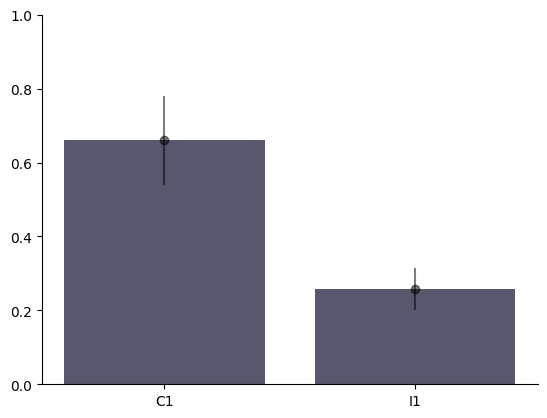

In [30]:
mean_esv={key: np.nanmean(value) for key, value in esv_neural.items()}
std_esv={key: np.nanstd(value) for key, value in esv_neural.items()}
neural_esv_df=pd.DataFrame(mean_esv, index=['mean'])
#sns.barplot(x=neural_esv_df.index, y=neural_esv_df.values)
neural_esv_df
sns.barplot(x=list(mean_esv.keys()), y=list(mean_esv.values()), color='#545570')#palette='Greys')
plt.errorbar(x=list(mean_esv.keys()), y=list(mean_esv.values()), yerr=list(std_esv.values()),c='k', fmt='o', alpha=0.5)
sns.despine()
plt.ylim(0, 1)
plt.savefig('neural_esv_c1_i1.pdf')

In [26]:
acc_mean_dic, acc_full_dic =process_one_bin(7,10)
#save(acc_mean_dic, 'results/acc_600_decoding_5f_122n_7_10_no_dd_splits')

291


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  

In [608]:
tasks=[(num_trials, i) for num_trials in subsampled.keys() for i in range(1  if num_trials==list(subsampled.keys())[-1] else 10)]
len(tasks)


281

In [37]:


def sigmoid(x, a1, b1, c1, d):
        sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
        return sigmoid1+d
    
def log_funct(x, a, b):
    return a * np.log(x) + b

def get_pcorr_extrapolation(x_data, y_data, std_data,plot, title,funct=sigmoid, start=1, end=100, log_scale=False, remove_thresh=0.001):
    #np.random.seed(0)
    #y_data=np.round(y_data,2)
    params, covariance = curve_fit(funct, x_data, y_data,maxfev = 5000000)
    loss = np.sum((y_data - funct(x_data, *params)) ** 2)
    print('loss',loss)
    if plot:
 
        x_extrapolated = np.linspace(start, end, 100)  # Adjust the range as needed
        y_extrapolated = funct(x_extrapolated, *params)

        plt.scatter(x_data, y_data, label='Original Data')
        plt.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='red')
        plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.5, c='gray', fmt='.')
        if log_scale:
            plt.xscale('log')
        plt.legend()
        plt.xlabel('number of existing trials taken')
        plt.ylabel('Partial correlation')
        sns.despine()
        plt.title(title)
        plt.show()
    if loss>remove_thresh:
        return np.nan, loss

    x, a, b,c,d = sp.symbols('x a b c d')
    # Define the functions
    sigmoid = a / (1 + sp.exp(-(x - b))/c) +d
    log = a * sp.log(x) + b
    # Substitute specific parameter values
    if funct ==  log_funct:
        print('using log')
        a_v, b_v= params 
        funct_with_values = log.subs({a: a_v, b: b_v})
    else:
        print('using sigmoid')
        a_v, b_v,c_v,d_v = params 
        funct_with_values = sigmoid.subs({a: a_v, b: b_v,c:c_v,d:d_v})
    # Substitute values into the sigmoid expression
    # Calculate the limit as x approaches positive infinity
    limit_at_infinity_specific = sp.limit(funct_with_values, x, sp.oo)

    return float(limit_at_infinity_specific), loss
def get_pcorr_limit_neurons(acc_neurons_subsb, title, idx=None, plot=False, remove_thresh=0.001): #acc_neurons_subsb for nb neurons seed
    
    neural_trials=acc_neurons_subsb#np.array([acc_neurons_subsb[key] for key in acc_neurons_subsb.keys()])
    x,y ='humans', 'pooled monkeys'
    df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]].iloc[idx]
    pcorr, esv=dict(), {}
    for i_trials in acc_neurons_subsb.keys():
        pcorr[i_trials], esv[i_trials]=[],[]
        i_seeds=10# if i_trials==9 else 10
        for i_seed in range(len(acc_neurons_subsb[i_trials])):
            #df_human_monkey=pd.DataFrame(get_beh_signatures_from_acc(all_trials[x][i_trials][i_seed])[signature], columns=[x])
            #df_human_monkey[y]=get_beh_signatures_from_acc(all_trials[y][i_trials][i_seed])[signature]
            df_model=pd.DataFrame(get_beh_signatures_from_acc(neural_trials[i_trials][i_seed])[signature])
            partial_correlation = pd.concat((df_human_monkey, df_model), axis=1).iloc[idx].pcorr()[x][y]
            pcorr[i_trials].append(partial_correlation)
            correlation_hm=df_human_monkey.corr()[x][y]#/(self_consistency[x][signature][0]*self_consistency[y][signature][0])
            esv[i_trials].append(((correlation_hm**2-partial_correlation**2)/(correlation_hm**2))*100)
            #if i_trials==9:
            #    print(signature, pcorr[i_trials])
    var_to_plot=pcorr
    limit, loss = get_pcorr_extrapolation(log_scale=False,x_data = list(range(1,31)),y_data = np.array([np.median(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), title=title,std_data= np.array([np.nanstd(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), plot=plot, remove_thresh=remove_thresh )
    limit_r = np.nan if limit >=0.9 else limit
    return limit_r, loss 



loss 0.04311097316370179


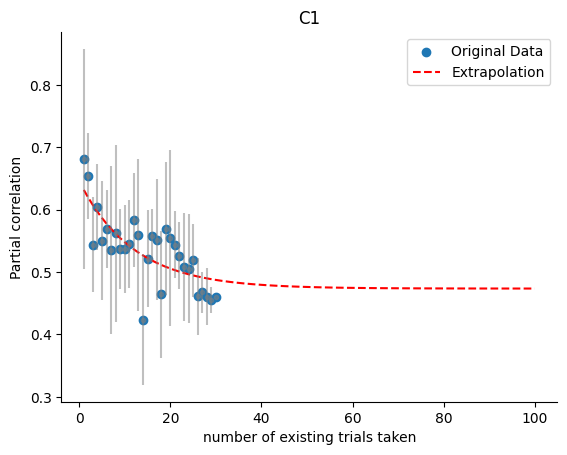

using sigmoid


In [39]:
signature='C1'
limit,loss = get_pcorr_limit_neurons(acc_mean_dic,title=signature, plot=True, idx=list(range(10 if signature=='C1' else 600)), remove_thresh=0.1)

In [118]:
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
beh_sig_models=pd.read_pickle('results/behavioral_signatures_models.pkl')
self_consistency= pd.read_pickle('results/self-consistency.pkl')
self_consistency.keys()

dict_keys(['primates', 'humans', 'Bento', 'Magneto', 'pooled monkeys', 'mean monkeys'])

In [44]:

def sigmoid(x, a1, b1, c1, d):
        sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
        return sigmoid1+d
    
def log_funct(x, a, b):
    return a * np.log(x) + b

def get_pcorr_extrapolation(x_data, y_data, std_data,plot, funct=sigmoid, start=10, end=300, log_scale=False, remove_thresh=0.001):
    #np.random.seed(0)
    #y_data=np.round(y_data,2)
    params, covariance = curve_fit(funct, x_data, y_data,maxfev = 5000000)
    loss = np.sum((y_data - funct(x_data, *params)) ** 2)
    
    if plot:
        x_extrapolated = np.linspace(start, end, 100)  # Adjust the range as needed
        y_extrapolated = funct(x_extrapolated, *params)

        plt.scatter(x_data, y_data, label='Original Data')
        plt.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='red')
        plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.5, c='gray', fmt='.')
        if log_scale:
            plt.xscale('log')
        plt.legend()
        plt.xlabel('% of existing trials taken')
        plt.ylabel('Partial correlation')
        sns.despine()
        plt.show()
    if loss>remove_thresh:
        return np.nan, loss

    x, a, b,c,d = sp.symbols('x a b c d')
    # Define the sigmoid function
    sigmoid = a / (1 + sp.exp(-(x - b))/c) +d
    # Substitute specific parameter values
    a_v, b_v,c_v,d_v = params 
    # Substitute values into the sigmoid expression
    sigmoid_with_values = sigmoid.subs({a: a_v, b: b_v,c:c_v,d:d_v})
    #asymptotic_expansion = sp.series(sigmoid_with_values, x, sp.oo, n=10)
    # Calculate the limit as x approaches positive infinity
    limit_at_infinity_specific = sp.limit(sigmoid_with_values, x, sp.oo)

    return float(limit_at_infinity_specific), loss

def get_pcorr_limit(acc_neurons_subsb, plot=False, remove_thresh=0.001): #acc_neurons_subsb for nb neurons seed
    neural_trials=np.array([acc_neurons_subsb[key] for key in acc_neurons_subsb.keys()])
    x,y ='humans', 'pooled monkeys'
    pcorr=dict()
    for i_trials in range(10):
        pcorr[i_trials]=[]
        i_seeds=10# if i_trials==9 else 10
        for i_seed in range(i_seeds):
            df_human_monkey=pd.DataFrame(get_beh_signatures_from_acc(all_trials[x][i_trials][i_seed])[signature], columns=[x])
            df_human_monkey[y]=get_beh_signatures_from_acc(all_trials[y][i_trials][i_seed])[signature]
            df_model=pd.DataFrame(get_beh_signatures_from_acc(neural_trials[i_trials][i_seed])[signature])
            pcorr[i_trials].append(pd.concat((df_human_monkey, df_model), axis=1).pcorr()[x][y])
            
    limit, loss = get_pcorr_extrapolation(x_data = list(range(10,110,10)),y_data = pd.DataFrame(pcorr).mean().values, std_data= pd.DataFrame(pcorr).std().values, plot=plot, remove_thresh=remove_thresh )
    return limit, loss

In [45]:
def get_pcorr_limit_all_decodes(acc_neurons_subsb, plot=False, remove_thresh=0.001): #acc_neurons_subsb for nb neurons seed
    import pingouin
    x,y ='humans', 'pooled monkeys'
    limits, losses=[],[]
    for decode_seed in range(10):
        neural_trials=np.array([acc_neurons_subsb[key][trials_subs][decode_seed] for key in acc_neurons_subsb.keys() for trials_subs in range(10)]).reshape(10,10,600)
        
        pcorr=dict()
        for i_trials in range(10):
            pcorr[i_trials]=[]
            for i_seed in range(10):
                df_human_monkey=pd.DataFrame(get_beh_signatures_from_acc(all_trials[x][i_trials][i_seed])[signature], columns=[x])
                df_human_monkey[y]=get_beh_signatures_from_acc(all_trials[y][i_trials][i_seed])[signature]
                df_model=pd.DataFrame(get_beh_signatures_from_acc(neural_trials[i_trials][i_seed])[signature])
                pcorr[i_trials].append(pd.concat((df_human_monkey, df_model), axis=1).pcorr()[x][y])
        limit, loss = get_pcorr_extrapolation(x_data = list(range(10,110,10)),y_data = pd.DataFrame(pcorr).mean().values, std_data= pd.DataFrame(pcorr).std().values, plot=plot, remove_thresh=remove_thresh )
        limits.append(limit)
        losses.append(loss)
    return limits, losses

In [59]:
#save(all_trials, 'results/all_trials_monkeys_humans')

In [48]:
def get_beh_signatures_from_acc(acc):
    
    I1_neural = acc
    C1_neural = [np.mean(I1_neural[i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)]
    C1_extended_neural = [C1_neural[i % NB_CONTEXT_TYPES] for i in range(NB_IMAGES)]
    I1n_neural = np.array(I1_neural)-np.array(C1_extended_neural)
    return {'I1': I1_neural,
                           'C1': np.array(C1_neural),
                           'I1n': I1n_neural
    }


In [ ]:


def sigmoid(x, a1, b1, c1, d):
        sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
        return sigmoid1+d
def log_funct(x, a, b):
    return a * np.log(x) + b


def get_pcorr_extrapolation(x_data, y_data, std_data,plot, title='title',funct=sigmoid, start=1, y_label='',end=80, log_scale=False, remove_thresh=0.001):
    #np.random.seed(0)
    #y_data=np.round(y_data,2)
    params, covariance = curve_fit(funct, x_data, y_data,maxfev = 5000000)
    loss = np.sum((y_data - funct(x_data, *params)) ** 2)
    
    if plot:
 
        x_extrapolated = np.linspace(start, end, 100)  # Adjust the range as needed
        y_extrapolated = funct(x_extrapolated, *params)

        plt.scatter(x_data, y_data, label='Original Data')
        plt.plot(x_extrapolated, y_extrapolated, label='Extrapolation', linestyle='--', color='red')
        plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.5, c='gray', fmt='.')
        if log_scale:
            plt.xscale('log')
        plt.legend()
        plt.title(title)
        plt.xlabel('number of existing trials taken')
        plt.ylabel(y_label)
        sns.despine()
        plt.show()
    if loss>remove_thresh:
        
        return np.nan, loss

    x, a, b,c,d = sp.symbols('x a b c d')
    # Define the sigmoid function
    sigmoid = a / (1 + sp.exp(-(x - b))/c) +d
    # Substitute specific parameter values
    a_v, b_v,c_v,d_v = params 
    # Substitute values into the sigmoid expression
    sigmoid_with_values = sigmoid.subs({a: a_v, b: b_v,c:c_v,d:d_v})
    #asymptotic_expansion = sp.series(sigmoid_with_values, x, sp.oo, n=10)
    # Calculate the limit as x approaches positive infinity
    limit_at_infinity_specific = sp.limit(sigmoid_with_values, x, sp.oo)

    return float(limit_at_infinity_specific), loss



In [50]:
def get_pcorr_limit_neurons(acc_neurons_subsb, title, idx=None, plot=False, remove_thresh=0.001): #acc_neurons_subsb for nb neurons seed
    import pingouin
    neural_trials=acc_neurons_subsb#np.array([acc_neurons_subsb[key] for key in acc_neurons_subsb.keys()])
    x,y ='humans', 'pooled monkeys'
    df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]].iloc[idx]
    pcorr, esv=dict(), {}
    for i_trials in acc_neurons_subsb.keys():
        pcorr[i_trials], esv[i_trials]=[],[]
        for i_seed in range(len(acc_neurons_subsb[i_trials])):
            #df_human_monkey=pd.DataFrame(get_beh_signatures_from_acc(all_trials[x][i_trials][i_seed])[signature], columns=[x])
            #df_human_monkey[y]=get_beh_signatures_from_acc(all_trials[y][i_trials][i_seed])[signature]
            df_model=pd.DataFrame(get_beh_signatures_from_acc(neural_trials[i_trials][i_seed])[signature])
            partial_correlation = pd.concat((df_human_monkey, df_model), axis=1).iloc[idx].pcorr()[x][y]
            pcorr[i_trials].append(partial_correlation)
            correlation_hm=df_human_monkey.corr()[x][y]#/(self_consistency[x][signature][0]*self_consistency[y][signature][0])
            esv[i_trials].append(((correlation_hm**2-partial_correlation**2)/(correlation_hm**2))*100)
            #if i_trials==9:
            #    print(signature, pcorr[i_trials])
    var_to_plot=pcorr
    #print(pcorr)
    limit, loss = get_pcorr_extrapolation(log_scale=False,y_label='Partial correlation' if var_to_plot==pcorr else '% Explained Variance by IT', x_data = list(var_to_plot.keys()),y_data = np.array([np.nanmean(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), title=title,std_data= np.array([np.nanstd(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), plot=plot, remove_thresh=remove_thresh )
    if var_to_plot==pcorr:
        limit_r = np.nan if (limit >=0.9) or (limit<=0) else limit
    else:
        limit_r= limit
    
    return limit_r, loss 

# Increasing the number of neurons

In [53]:
from joblib import Parallel, delayed
import numpy as np
from decode_utils import get_percent_correct_from_proba
all_neurons=122
acc_diff_rates_all=dict()
# Define a function to handle the processing for each num_neurons
def process_num_neurons(num_neurons, reliable_neurons):
    acc_diff_rates = {}
    std_acc_diff_rates = {}
    
    list_neuron_idxs = list(range(all_neurons))
    nb_seeds=10 if num_neurons < 121 else 1
    for shuffle_seed in range(10):
        unq_seed=hash((num_neurons, shuffle_seed)) & ((1 << 32) - 1)
        acc_diff_rates[shuffle_seed], std_acc_diff_rates[shuffle_seed] = {}, {}
        np.random.seed(unq_seed)
        list_neuron_idxs = np.random.permutation(list_neuron_idxs)
        
        trials = reliable_neurons[:, :,list_neuron_idxs[:num_neurons]]
        neural_trial_splits=subsample_trials(trials, list(range(1,31,2)))
        for num_trials in neural_trial_splits.keys():
            acc_diff_rates[shuffle_seed][num_trials], std_acc_diff_rates[shuffle_seed][num_trials]=[],[]
            i_seeds=1 if num_trials==list(neural_trial_splits.keys())[-1] else 10
            for i in range(i_seeds):
                features=neural_trial_splits[num_trials][i].mean(axis=1).T
                acc_all=[]
                for j in range(5):
                    acc,p = decode(features, labels, nrfolds=5, seed=j)
                    pc=get_percent_correct_from_proba(p,labels)
                    acc_all.append(np.nanmean(pc, axis=1))
            
                acc_diff_rates[shuffle_seed][num_trials].append(np.array(acc_all).mean(axis=0))
                std_acc_diff_rates[shuffle_seed][num_trials].append(acc_all)
    #save(acc_diff_rates, f'results/no_dd/acc_increase_7_17/{num_neurons}')


acc_diff_rates = {}
std_acc_diff_rates = {}
num_ns = 123
start, end = 7, 17
Parallel(n_jobs=-1,  verbose=20)(
    delayed(process_num_neurons)(num_neurons, reliable_neurons_7_17)
    for num_neurons in range(5, num_ns,1)
)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

KeyboardInterrupt: 

In [51]:
import os
files=os.listdir('results/no_dd/acc_increase_7_17/')
acc_all_neurons=dict()
for file in files:
    nb_neurons=int(file.removesuffix('.pkl'))
    acc = pd.read_pickle('results/no_dd/acc_increase_7_17/'+file)
    acc_all_neurons[nb_neurons]=acc


In [ ]:
limits, losses=dict(), dict()
#acc_diff_rates=pd.read_pickle('results/full_acc_600_decoding_2f_increase_n_10-18_122_splits_trials_.pkl')
signature='C1'
remove_thresh=0.001 if signature=='I1' else 0.05
acc_diff_rates=acc_all_neurons
for nb_neurons in np.sort(list(acc_diff_rates.keys()))[:]:
    limits[nb_neurons]=[]
    losses[nb_neurons]=[]
    for seed in range(10):

        l,loss = get_pcorr_limit_neurons(acc_diff_rates[nb_neurons][seed], title=f'number of neurons: {nb_neurons}, seed: {seed}', plot=True,remove_thresh=remove_thresh,idx=list(range(10)))

        print(f'limit: {l}, loss {loss}, nb_neurons: {nb_neurons}, seed: {seed}')
        limits[nb_neurons].append(np.nanmean(l))
        losses[nb_neurons].append(np.nanmean(loss))

In [54]:
import pandas as pd
from joblib import Parallel, delayed

signature='C1'
remove_thresh=0.001 if signature=='I1' else 0.05


acc_diff_rates=acc_all_neurons

limits, losses = dict(), dict()


# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_pcorr_limit_neurons)(acc_diff_rates[nb_neurons][seed], remove_thresh=remove_thresh,title='',idx=list(range(600 if signature=='I1' else 10))) for nb_neurons in list(acc_diff_rates.keys()) for seed in range(10))




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the envir

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    4.4s
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    4.8s
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpac

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    7.9s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minp

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimiz

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning:

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   28.5s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__g

[Parallel(n_jobs=-1)]: Done 905 tasks      | elapsed:   31.3s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the paramet

/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25819/3704316334.py:2: RuntimeWarning: overflow encountered in exp
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the paramet

In [55]:
tasks = [(nb_neurons, seed) for nb_neurons in list(acc_diff_rates.keys()) for seed in range(10)]
limits, losses = dict(), dict()
for result, key in zip(results,tasks):
    limit, loss = result
    num_neurons, shuffle_seed=key[0], key[1]
    if num_neurons not in limits:
        limits[num_neurons],losses[num_neurons] =[],[]
    limits[num_neurons].append(np.nanmean(limit))
    losses[num_neurons].append(np.nanmean(loss))
    
    
    save_str=f'{signature}_increasing_neurons_7-17_subsampling'
    #save(limits, f'results/pcor_{save_str}')
    #save(losses, f'results/loss_{save_str}')
    





In [56]:
import pandas as pd
from joblib import Parallel, delayed
def get_corr_sbj(neural_data, signature):
    x,y='humans', 'pooled monkeys'
    beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
    mh_df = pd.DataFrame(beh_sig_sbj[signature])[[x,y]]
    corr_h, corr_m=[],[]
    for i in neural_data.keys():
        neural_signature=pd.DataFrame(get_beh_signatures_from_acc(neural_data[i])[signature])
        corr_h.append(pd.concat((neural_signature,mh_df
                                ), axis=1).corr()[x][0])
        corr_m.append(pd.concat((neural_signature,  mh_df), axis=1).corr()[y][0])
    return corr_h, corr_m
signature='C1'
remove_thresh=0.001 if signature=='I1' else 0.05


acc_diff_rates=pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_increase_n_7-10_pc_no_dd.pkl')

limits, losses = dict(), dict()


# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_corr_sbj)(acc_diff_rates[nb_neurons], signature) for nb_neurons in acc_diff_rates.keys())

tasks = [nb_neurons for nb_neurons in acc_diff_rates.keys()]
corr_h, corr_m = dict(), dict()
for result, key in zip(results,tasks):
    corr_h[key]= result[0]
    corr_m[key]=result[1]
    
    
    
    save_str=f'{signature}_increasing_neurons_7-17_subsampling'
    #save(corr_h, f'results/corr_humans_{save_str}')
    #save(corr_m, f'results/corr_monkeys_{save_str}')
   


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0106s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0616s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0425s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 112 out of 119 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    0.1s finished


In [64]:
x,y='humans', 'pooled monkeys'

limits_c1=pd.read_pickle('results/pcor_C1_increasing_neurons_7-17_subsampling.pkl')
limits_i1=pd.read_pickle('results/pcor_I1_increasing_neurons_7-17_subsampling.pkl')

losses_i1=pd.read_pickle('results/loss_I1_increasing_neurons_7-17_subsampling.pkl')
losses_c1=pd.read_pickle('results/loss_C1_increasing_neurons_7-17_subsampling.pkl')
corr_h_c1=pd.read_pickle('results/corr_humans_C1_increasing_neurons_7-17_subsampling.pkl')
corr_h_i1=pd.read_pickle('results/corr_humans_I1_increasing_neurons_7-17_subsampling.pkl')
corr_m_i1=pd.read_pickle('results/corr_monkeys_I1_increasing_neurons_7-17_subsampling.pkl')
corr_m_c1=pd.read_pickle('results/corr_monkeys_C1_increasing_neurons_7-17_subsampling.pkl')




self_consistency=pd.read_pickle('results/self-consistency.pkl')
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
esv = dict()
std=dict()
mh_df_i1 = pd.DataFrame(beh_sig_sbj['I1'])[[x,y]]
mh_df_c1 = pd.DataFrame(beh_sig_sbj['C1'])[[x,y]]

corr_i1 = mh_df_i1.corr()[x][y]#/(self_consistency['humans']['I1'][0]*self_consistency['pooled monkeys']['I1'][0])
corr_c1 = mh_df_c1.corr()[x][y]#/(self_consistency['humans']['C1'][0]*self_consistency['pooled monkeys']['C1'][0])

all_info={'esv I1':{'mean':{}, 'std':{}},
        'pcor I1':{'mean':{}, 'std':{}},
          'corr h I1':{'mean':{}, 'std':{}},
          'corr h C1':{'mean':{}, 'std':{}},
          'corr m I1':{'mean':{}, 'std':{}},
          'corr m C1':{'mean':{}, 'std':{}},
          'loss I1':{'mean':{}, 'std':{}},
          'loss C1':{'mean':{}, 'std':{}},
        'esv C1':{'mean':{}, 'std':{}},
        'pcor C1':{'mean':{}, 'std':{}},
        'loss':{'mean':{}, 'std':{}},
         }

for nb_neurons in limits_i1.keys():
    all_info['corr h I1']['mean'][nb_neurons]= np.nanmean(corr_h_i1[nb_neurons])
    all_info['corr h I1']['std'][nb_neurons]= np.nanstd(corr_h_i1[nb_neurons])
    all_info['corr h C1']['mean'][nb_neurons]= np.nanmean(corr_h_c1[nb_neurons])
    all_info['corr h C1']['std'][nb_neurons]= np.nanstd(corr_h_c1[nb_neurons])
    all_info['corr m I1']['mean'][nb_neurons]= np.nanmean(corr_m_i1[nb_neurons])
    all_info['corr m I1']['std'][nb_neurons]= np.nanstd(corr_m_i1[nb_neurons])
    all_info['corr m C1']['mean'][nb_neurons]= np.nanmean(corr_m_c1[nb_neurons])
    all_info['corr m C1']['std'][nb_neurons]= np.nanstd(corr_m_c1[nb_neurons])
    all_info['pcor I1']['mean'][nb_neurons]= np.nanmean(limits_i1[nb_neurons])
    all_info['pcor I1']['std'][nb_neurons]= np.nanstd(limits_i1[nb_neurons])
    all_info['loss I1']['mean'][nb_neurons]= np.nanmean(losses_i1[nb_neurons])
    all_info['loss I1']['std'][nb_neurons]= np.nanstd(losses_i1[nb_neurons])
    all_info['loss C1']['mean'][nb_neurons]= np.nanmean(losses_c1[nb_neurons])
    all_info['loss C1']['std'][nb_neurons]= np.nanstd(losses_c1[nb_neurons])

    all_info['pcor C1']['mean'][nb_neurons]= np.nanmean(limits_c1[nb_neurons])
    all_info['pcor C1']['std'][nb_neurons]= np.nanstd(limits_c1[nb_neurons])


    df= pd.DataFrame(limits_i1[nb_neurons])
    all_seeds_esv=(1-(df**2/corr_i1**2))*100
    all_info['esv I1']['std'][nb_neurons]=all_seeds_esv.std()[0]
    all_info['esv I1']['mean'][nb_neurons]=all_seeds_esv.mean()[0]
    
    df= pd.DataFrame(limits_c1[nb_neurons])
    all_seeds_esv=(1-(df**2/corr_c1**2))*100
    all_info['esv C1']['std'][nb_neurons]=all_seeds_esv.std()[0]
    all_info['esv C1']['mean'][nb_neurons]=all_seeds_esv.mean()[0]


save(all_info, 'results/all_info_increasing_n_7-17')

In [65]:
all_info=pd.read_pickle('results/all_info_increasing_n_7-17.pkl')
all_info.keys()

dict_keys(['esv I1', 'pcor I1', 'corr h I1', 'corr h C1', 'corr m I1', 'corr m C1', 'loss I1', 'loss C1', 'esv C1', 'pcor C1', 'loss'])

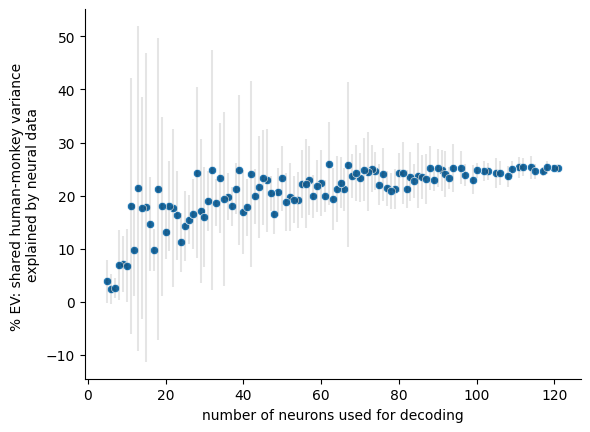

In [86]:
#all_info =pd.read_pickle('results/all_info_sigmoid_extrapolation.pkl')
param='esv I1'
df = pd.DataFrame(all_info[param])
df=df.reset_index()
df=df[df['index']>0]
sns.scatterplot(data=df, x='index', y='mean')
plt.errorbar(x=df['index'], y=df['mean'], yerr=df['std'], fmt='.',alpha=0.1, c='k')
plt.xlabel('number of neurons used for decoding')
title= 'corrected partial correlation (limit)' if param=='limit' else 'fitting extrapolation loss' if param=='loss' else '% EV: shared human-monkey variance \nexplained by neural data'
plt.ylabel(title)
sns.despine()
#plt.xscale('log')
plt.show()


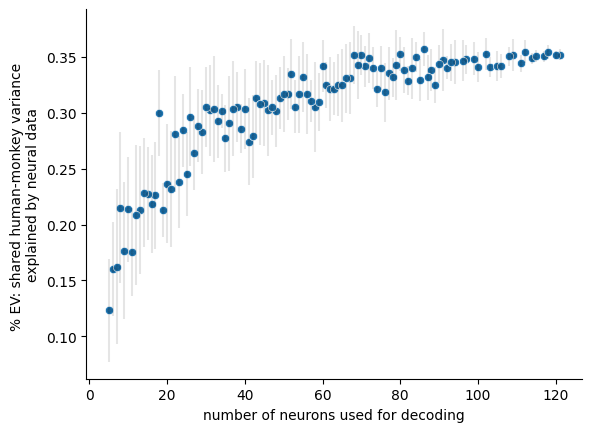

In [67]:

#all_info =pd.read_pickle('results/all_info_sigmoid_extrapolation.pkl')
signature='I1'
param=f'corr m {signature}'#f'esv {signature}'
df = pd.DataFrame(all_info[param])
df = df[df['std']<10]
df=df.reset_index()
df=df[df['index']>0]
sns.scatterplot(data=df, x='index', y='mean')
plt.errorbar(x=df['index'], y=df['mean'], yerr=df['std'], fmt='.',alpha=0.1, c='k')
plt.xlabel('number of neurons used for decoding')
title= 'corrected partial correlation (limit)' if param=='limit' else 'fitting extrapolation loss' if param=='loss' else '% EV: shared human-monkey variance \nexplained by neural data'
plt.ylabel(title)
sns.despine()
#plt.xscale('log')
plt.show()


In [68]:
acc_diff_rates=pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_increase_n_7-10_pc_no_dd.pkl')
acc_increase_neurons = pd.DataFrame(acc_diff_rates).applymap(lambda x: np.mean(x))#.applymap(lambda x: np.mean(x[30][1]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


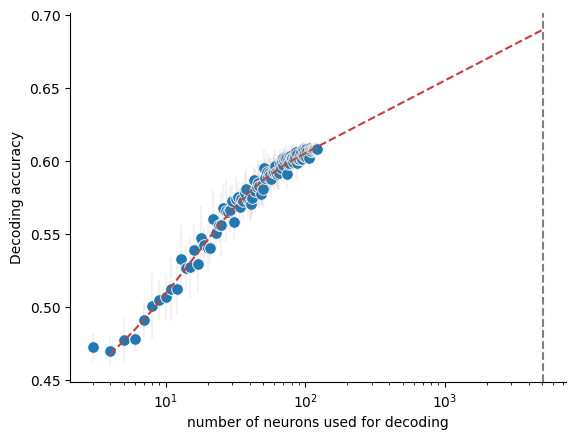

Loss: 0.0019 5113 0.6904552619677746


In [70]:
from scipy.optimize import curve_fit
param='mean accuracy'
acc_diff_rates=pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_increase_n_7-10_pc_no_dd.pkl')
acc_increase_neurons = pd.DataFrame(acc_diff_rates).applymap(lambda x: np.mean(x))#.applymap(lambda x: np.mean(x[30][1]))
#acc_increase_neurons=df_summary[param]
acc_increase_neurons=acc_increase_neurons.drop(columns=[58])
x_data = np.array(list(acc_increase_neurons.mean().index))##np.array(list(mean_cons.keys()))#np.linspace(-10, 10, 100)
y_data =np.array(list(acc_increase_neurons.mean().values))# 5 / (1 + np.exp(-(x_data - 2)/1)) + 2 / (1 + np.exp((x_data + 4)/1.5)) + np.random.normal(0, 0.2, len(x_data))
std_data=np.array(list(acc_increase_neurons.std().values))
monkey_acc=pd.read_pickle('results/behavioral_signatures_primates.pkl')['I1']['pooled monkeys'].mean()


# Define the function with two sigmoid components
def mix_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a,b,d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    #return a3*sigmoid1*sigmoid2+a*x**b
    #return a3*sigmoid1+a*np.sqrt(x)**b
    return sigmoid1+sigmoid2+a3*np.log(b*np.abs(x)+d)
    #return a3*np.log(b*np.abs(x)+d)
    #return  sigmoid3**2*sigmoid2*sigmoid1**8+ sigmoid1+a * x**b
    #return np.log(sigmoid1)*sigmoid2**2+np.log(sigmoid3)+d
    #return (sigmoid1)**2*np.sqrt(sigmoid2)+np.sqrt(sigmoid3)+d
    #return sigmoid1*sigmoid2+np.log(sigmoid3)+d#np.log(sigmoid1)+d
def power_law(x, a, b):
    return a * x**b
funct=mix_sigmoid
start_num=1

# Fit the function to the data
params, covariance = curve_fit(funct, x_data[start_num:], y_data[start_num:], maxfev=5000000)

for i in range(x_data[start_num:][-1],10000):
    y_i = funct([i], *params)
    if y_i>=monkey_acc:
        break

x_new = np.array(list(range(x_data[start_num:][-1], i+1, 1)))#,300,350,357])
#x_new =np.append(x_new, i)

# Generate data points from the fitted function for plotting
x_fit =  np.concatenate((x_data[start_num:], x_new), axis=0).T#np.linspace(min(x_data), max(x_data), 1000)
y_fit = funct(x_fit, *params)
data_acc = pd.DataFrame(x_data, columns=['x'])
data_acc['y']=y_data
# Plot the data and the fit
g= sns.scatterplot(data=data_acc,x='x', y='y',  label='actual',legend=False, alpha=1,s=70)


g.axvline(x=x_new[-1], linestyle='dashed', label=True, color='grey')
plt.xscale('log')

plt.plot(x_fit[0:], y_fit[0:], color='#C53F3B', linestyle='--', label='Fit')

plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.1, c='gray', fmt='None')

sns.despine()


plt.xlabel('number of neurons used for decoding')

plt.ylabel('Decoding accuracy')

plt.savefig('acc extrapolate70-170.eps')

plt.show()

# Calculate the loss
loss = np.sum((y_data - funct(x_data, *params)) ** 2)
print(f"Loss: {loss:.4f} {i} {y_fit[-1]}")





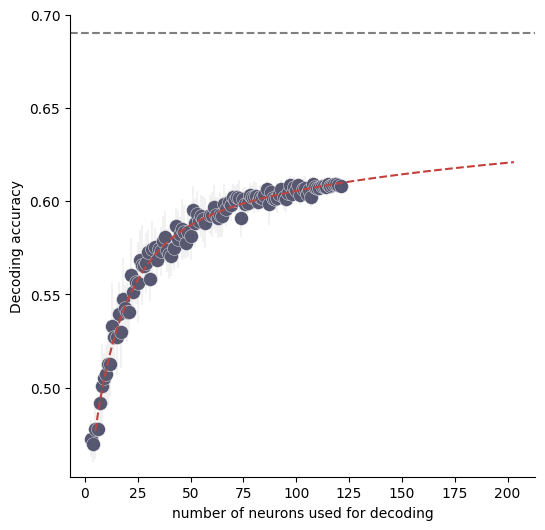

In [71]:
plt.figure(figsize=(6, 6))
g= sns.scatterplot(data=data_acc,x='x', y='y', c='#545570', linewidth=0.3,label='actual',edgecolor='w',legend=False, alpha=1,s=100)
#545570

#g.axvline(x=x_new[-1], linestyle='dashed', label=True, color='grey')
#plt.xscale('log')
end=200
plt.plot(x_fit[1:end], y_fit[1:end], color='#C53F3B', linestyle='--', label='Fit')

plt.errorbar(x_data, y_data, yerr=std_data, alpha=0.1, c='gray', fmt='None')

sns.despine()
plt.ylim(None, 0.7)
plt.axhline(y=monkey_acc, c='gray', linestyle='dashed')
plt.xlabel('number of neurons used for decoding')

plt.ylabel('Decoding accuracy')

#plt.savefig('acc extrapolate70-170.eps')
#plt.savefig('acc extrapolate70-170.pdf')

plt.show()

122  reliable neurons 0.1, nr images:  600


In [265]:
import numpy as np
from joblib import Parallel, delayed

# Function to perform the iteration for a given num_neurons and shuffle_seed
def iterate(num_neurons, shuffle_seed, mean_reliable_neurons):
    unq_seed=hash((num_neurons, shuffle_seed)) & ((1 << 32) - 1)
    np.random.seed(unq_seed)
    list_neuron_idxs = np.random.permutation(list(range(all_neurons)))
    acc_diff, dp_diff, std_acc_diff = dict(), dict(), dict()
    features = mean_reliable_neurons[list_neuron_idxs[:num_neurons], :]

    acc_all = []
    
    for j in range(10):
        acc,p = decode(features, labels, nrfolds=5, seed=j)
        pc=get_percent_correct_from_proba(p,labels)
        acc_all.append(np.nanmean(pc, axis=1))

    acc_diff = np.array(acc_all).mean(axis=0)
    std_acc_diff = acc_all #np.array(acc_all).std(axis=0)

    return num_neurons, shuffle_seed, acc_diff, std_acc_diff

# Parallel execution of the loop
acc_diff_rates, dp_diff_rates, std_acc_diff_rates = dict(), dict(), dict()

mean_reliable_neurons_7_17=reliable_neurons_7_17.swapaxes(1,2).mean(axis=2).T
nrImages = mean_reliable_neurons_7_17.shape[1]
all_neurons=mean_reliable_neurons_7_17.shape[0]
print(all_neurons, ' reliable neurons 0.1, nr images: ', nrImages)



tasks = [(num_neurons, shuffle_seed) for num_neurons in range(3, all_neurons) for shuffle_seed in range(10)]

# Parallel execution using joblib
results = Parallel(n_jobs=-1, verbose=20)(
    delayed(iterate)(num_neurons, shuffle_seed, mean_reliable_neurons_10_18) for num_neurons, shuffle_seed in tasks
)


save_str = f'600_decoding_5f_{all_neurons}neurons_increase_n_7-10_pc_no_dd'



for result in results:
    num_neurons, shuffle_seed, acc, std_acc = result
    print(num_neurons, shuffle_seed)
    if num_neurons not in acc_diff_rates:
        acc_diff_rates[num_neurons] = dict()
        
        std_acc_diff_rates[num_neurons] = dict()

    acc_diff_rates[num_neurons][shuffle_seed] = acc
    
    std_acc_diff_rates[num_neurons][shuffle_seed] = std_acc

    save(acc_diff_rates, f'results/acc_{save_str}')
    save(std_acc_diff_rates, f'results/full_acc_{save_str}')
    




122  reliable neurons 0.1, nr images:  600


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 1

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 15.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 17.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 19.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed: 21.2min
[Paralle

[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed: 23.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed: 25.4min
[Paralle

[Parallel(n_jobs=-1)]: Done 930 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 931 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 932 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 935 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 937 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 939 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 940 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 941 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 943 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 945 tasks      | elapsed: 27.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 1062 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done 1063 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1065 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1067 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1068 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1069 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 1070 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1071 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1073 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1074 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1075 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 1077 tasks      | elapsed: 

3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9
22 0
22 1
22 2
22 3
22 4
22 5
22 6
22 7
22 8
22 9
23 0
23 1
23 2
23 3
23 4
23 5
23 6
23 7
23 8
23 9
24 0
24 1
24 2
24 3


## Get the explained shared variance

In [92]:


#self_consistency=pd.read_pickle('results/self-consistency.pkl')
splits=dict()


model='Neural'
correct=False
signature='I1'

x, y ='pooled monkeys', 'humans'
df_monkey_human = pd.DataFrame(beh_sig_sbj[signature])[[x,y]]#.drop(columns=['primates', 'Bento', 'Magneto']) 

acc_neurons_increasing = pd.read_pickle('results/acc_600_decoding_2f_122neurons_subsampleavg_10-18_scaler_svm.pkl')
results_info={'pcorr correction': {},'esv corrected': {},'esv not corrected': {}, 'corr monkeys': {}, 'corr humans': {},  'mean acc subsampling': {}, 'pcorr corrected': {}, 'pcorr not corrected': {}}
_ = [results_info[key].update({num_neurons: {}}) for key in results_info for num_neurons in acc_neurons_increasing.keys()]
_ = [results_info[key][num_neurons].update({shuffle_seed: []}) for key in results_info for num_neurons in acc_neurons_increasing.keys() for shuffle_seed in range(10)]
self_consistency_res=pd.read_pickle('results/self_consistency_res_increasing_neurons_122_10_18_no_subsampling_svm.pkl')

for num_neurons in acc_neurons_increasing.keys():
    
    for shuffle_seed in range(10):
        
        df_model=pd.DataFrame(acc_neurons_increasing[num_neurons][shuffle_seed])
  
        consistency_x_res = distribution_info(self_consistency_res[( num_neurons, shuffle_seed)][x])[0]
        consistency_y_res = distribution_info(self_consistency_res[( num_neurons, shuffle_seed)][y])[0]
        acc_per_neuron_seed=acc_neurons_increasing[num_neurons][shuffle_seed]
        results_info['mean acc subsampling'][num_neurons][shuffle_seed].append(acc_per_neuron_seed.mean())
        """
        results_info['esv not corrected'][num_neurons][shuffle_seed].append(get_esv(df_monkey_human,df_model, x,y,1,correct=False)[0])
        results_info['esv corrected'][num_neurons][shuffle_seed].append(get_esv(df_monkey_human,df_model, x,y,consistency_x_res*consistency_y_res,correct=True)[0])
        results_info['corr monkeys'][num_neurons][shuffle_seed].append(np.corrcoef(acc_per_neuron_seed, np.array(beh_sig_sbj[signature][x]))[0,1])
        results_info['corr humans'][num_neurons][shuffle_seed].append(np.corrcoef(acc_per_neuron_seed, np.array(beh_sig_sbj[signature][y]))[0,1])
        results_info['pcorr correction'][num_neurons][shuffle_seed].append(consistency_x_res*consistency_y_res)
        results_info['pcorr not corrected'][num_neurons][shuffle_seed].append(get_esv(df_monkey_human,df_model, x,y,1,correct=False)[2])
        results_info['pcorr corrected'][num_neurons][shuffle_seed].append(get_esv(df_monkey_human,df_model, x,y,consistency_x_res*consistency_y_res,correct=True)[2])
        """


In [96]:
df_summary[['mean accuracy', ]]

,mean accuracy
3,0.156050
4,0.155167
5,0.192233
6,0.203533
7,0.214217
...,...
117,0.575450
118,0.574283
119,0.572000
120,0.575350


StopIteration: 

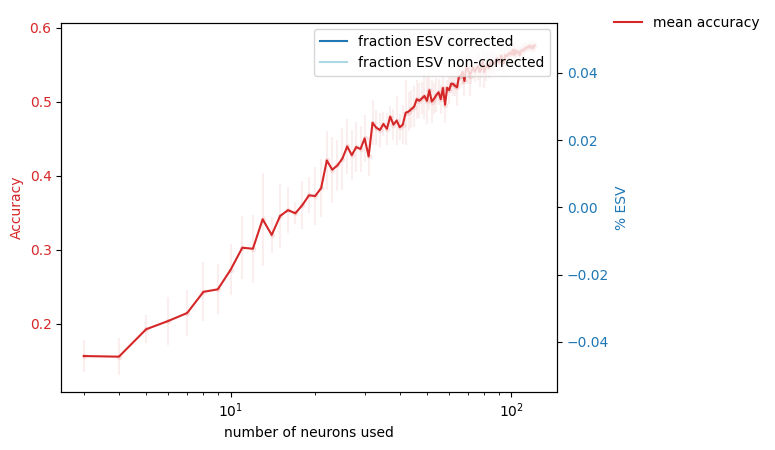

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming mean_acc_subsam, pcorr_cor, and pcor are already defined

# Create a DataFrame from mean_acc_subsam
df = pd.DataFrame(results_info['mean acc subsampling'])

# Calculate mean and standard deviation for each column in mean_acc_subsam
mean_values = df.applymap(np.mean).mean()
std_values = df.applymap(np.mean).std()

# Create a DataFrame with mean and standard deviation
df_summary = pd.DataFrame({'mean accuracy': mean_values,
                            'std mean accuracy': std_values,
                            'fraction ESV corrected': pd.DataFrame(results_info['esv corrected']).applymap(np.mean).mean(),
                           'std fraction ESV corrected': pd.DataFrame(results_info['esv corrected']).applymap(np.mean).std(),
                            'fraction ESV non-corrected': pd.DataFrame(results_info['esv not corrected']).applymap(np.mean).mean(),
                          'std fraction ESV non-corrected': pd.DataFrame(results_info['esv not corrected']).applymap(np.mean).std()})

# Plot the mean lines
fig, ax1 = plt.subplots()
plt.xscale('log')
color = 'tab:red'
df_summary[['mean accuracy', ]].plot(ax=ax1, color=[color, color, color])
ax1.set_xlabel('number of neurons used')
ax1.set_ylabel('Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='center left', bbox_to_anchor=(1.09, 1), frameon=False)
ax1.errorbar(df_summary.index, df_summary['mean accuracy'], yerr=df_summary['std mean accuracy'],alpha=0.08, color=color, fmt='.')




# Create the second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
(df_summary[['fraction ESV corrected','fraction ESV non-corrected']]*100).plot(ax=ax2, color=['tab:blue', 'lightblue'])
ax2.set_ylabel('% ESV', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar(df_summary.index, df_summary['fraction ESV corrected']*100, yerr=df_summary['std fraction ESV corrected']*100,alpha=0.08, color='tab:blue', fmt='.')
ax2.errorbar(df_summary.index, df_summary['fraction ESV non-corrected']*100, yerr=df_summary['std fraction ESV non-corrected']*100,alpha=0.08, color='lightblue', fmt='.')
plt.legend(loc='upper left', bbox_to_anchor=(1.09, 1), frameon=False)


sns.despine(trim=False,left=False, right=False)
# Set up the plot

plt.title('Using SVM with 5 folds CV')
plt.show()



In [98]:
def double_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    return np.log(sigmoid1)*sigmoid2**2+np.log(sigmoid3)+d

# Extrapolate neurons

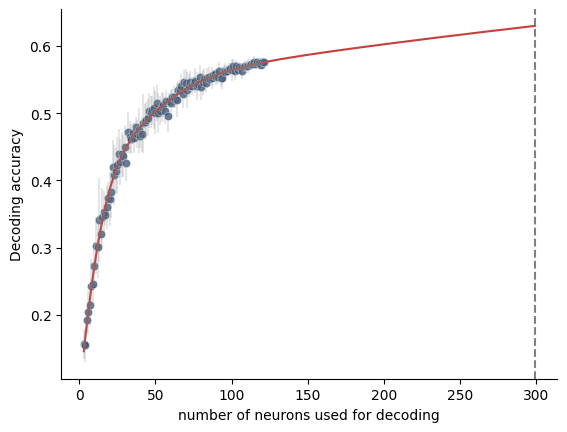

Loss: 0.0061 299 0.6297563146762366


In [100]:
from scipy.optimize import curve_fit
param='mean accuracy'
x_data = np.array(list(df_summary[param].index))##np.array(list(mean_cons.keys()))#np.linspace(-10, 10, 100)
y_data =np.array(list(df_summary[param].values))# 5 / (1 + np.exp(-(x_data - 2)/1)) + 2 / (1 + np.exp((x_data + 4)/1.5)) + np.random.normal(0, 0.2, len(x_data))
std_data=np.array(list(df_summary[f'std {param}'].values))
monkey_acc=pd.read_pickle('results/behavioral_signatures_primates.pkl')['I1']['pooled monkeys'].mean()


# Define the function with two sigmoid components
def mix_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    #return np.log(sigmoid1)**2*np.log(sigmoid2)+d
    #return np.log(sigmoid1)**2*(sigmoid2)+d
    return np.log(sigmoid1)*sigmoid2**2+np.log(sigmoid3)+d
start_num=0

# Fit the function to the data
params, covariance = curve_fit(mix_sigmoid, x_data[start_num:], y_data[start_num:], maxfev=5000000)

for i in range(x_data[start_num:][-1],300):
    y_i = mix_sigmoid([i], *params)
    if y_i>=monkey_acc:
        break

x_new = np.array(list(range(x_data[start_num:][-1], i+1, 1)))#,300,350,357])
#x_new =np.append(x_new, i)

# Generate data points from the fitted function for plotting
x_fit =  np.concatenate((x_data[start_num:], x_new), axis=0).T#np.linspace(min(x_data), max(x_data), 1000)
y_fit = mix_sigmoid(x_fit, *params)
data_acc = pd.DataFrame(x_data, columns=['x'])
data_acc['y']=y_data
# Plot the data and the fit
g= sns.scatterplot(data=data_acc,x='x', y='y',  label='actual',legend=False, color='#174173',alpha=0.7)


g.axvline(x=x_new[-1], linestyle='dashed', label=True, color='grey')
#plt.xscale('log')

plt.plot(x_fit[0:], y_fit[0:], color='#C53F3B', label='Fit')

plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.2, c='gray', fmt='.')

sns.despine()


plt.xlabel('number of neurons used for decoding')

plt.ylabel('Decoding accuracy')

plt.savefig('acc extrapolate10-180.pdf')



plt.show()

# Calculate the loss
loss = np.sum((y_data - mix_sigmoid(x_data, *params)) ** 2)
print(f"Loss: {loss:.4f} {i} {y_fit[-1]}")




In [ ]:
#return np.log(sigmoid1)**2*(sigmoid2)+d

In [101]:
from scipy.optimize import curve_fit
param='fraction ESV corrected'
x_data = np.array(list(df_summary[param].index))##np.array(list(mean_cons.keys()))#np.linspace(-10, 10, 100)
y_data =np.array(list(df_summary[param].values))# 5 / (1 + np.exp(-(x_data - 2)/1)) + 2 / (1 + np.exp((x_data + 4)/1.5)) + np.random.normal(0, 0.2, len(x_data))
std_data=np.array(list(df_summary[f'std {param}'].values))
monkey_acc=pd.read_pickle('results/behavioral_signatures_primates.pkl')['I1']['pooled monkeys'].mean()


# Define the function with two sigmoid components
def double_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    #return np.log(sigmoid1)**2*(sigmoid2)+d
    return np.log(sigmoid1)**2*np.log(sigmoid2)+d
start_num=0
# Fit the function to the data
params, covariance = curve_fit(double_sigmoid, x_data[start_num:], y_data[start_num:], maxfev=50000)

x_new = np.array(list(range(x_data[start_num:][-1], i+1, 1)))#,300,350,357])
#x_new =np.append(x_new, i)

# Generate data points from the fitted function for plotting
x_fit =  np.concatenate((x_data[start_num:], x_new), axis=0).T#np.linspace(min(x_data), max(x_data), 1000)
y_fit = double_sigmoid(x_fit, *params)
data_acc = pd.DataFrame(x_data, columns=['x'])
data_acc['y']=y_data
# Plot the data and the fit
g= sns.scatterplot(data=data_acc,x='x', y='y',  label='actual',legend=False, color='#174173',alpha=0.7)


g.axvline(x=x_new[-1], linestyle='dashed', label=True, color='grey')
g.axhline(y=y_fit[-1], linestyle='dashed', label=True, color='grey')

plt.xscale('log')

plt.plot(x_fit[:], y_fit[:], color='#C53F3B', label='Fit')

plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.2, c='gray', fmt='.')

sns.despine()


plt.xlabel('number of neurons used for decoding')

plt.ylabel('Fraction of explained shared variance')


plt.savefig('ESV extrapolate10-180.pdf')
plt.show()

# Calculate the loss
loss = np.sum((y_data - double_sigmoid(x_data, *params)) ** 2)
print(f"Loss: {loss:.2f} {i} {y_fit[-1]}")


ValueError: array must not contain infs or NaNs

In [94]:
df_res_rel = pd.DataFrame(self_consistency_res).applymap(lambda x: distribution_info(x)[0])
df_res_rel.columns.names=['num_neurons','shuffle seed']
df_res_rel = df_res_rel.T
df_res_rel['humans*monkeys']=df_res_rel['humans']*df_res_rel['pooled monkeys']

df_res_rel=df_res_rel**2
df_res_rel_mean = df_res_rel.T.groupby(level='num_neurons', axis=1).mean().T

df_res_rel_std=df_res_rel.T.groupby(level='num_neurons', axis=1).std().T
df_res_rel_std

,pooled monkeys,humans,humans*monkeys
num_neurons,,,
3,0.007283,0.007405,0.010757
4,0.008462,0.010626,0.013947
5,0.012266,0.009776,0.015839
6,0.013954,0.010560,0.018125
7,0.008595,0.010457,0.013720
...,...,...,...
117,0.002443,0.003473,0.003598
118,0.001788,0.001967,0.002217
119,0.002110,0.002454,0.002717


# Analysis all timebins

In [20]:
valid_trials_per_sbj=pd.read_pickle('results/valid_trials_per_sbj.pkl')



In [126]:
from joblib import Parallel, delayed
import numpy as np
from decode_utils import get_percent_correct_from_proba
# Define a function to handle the processing for each start and length combination
def process_start_length(start, length, pooled_rates_full):
    acc_diff_rates = dict()
    std_acc_diff_rates = dict()
    trials = pooled_rates_full[:, :30, start:start + length, reliable_rates].mean(axis=2)
    #trials = reliable_neurons[:, :,list_neuron_idxs[:num_neurons]]
    neural_trial_splits=subsample_trials(trials, list(range(1,31,2)))
    for num_trials in neural_trial_splits.keys():
        acc_diff_rates[num_trials], std_acc_diff_rates[num_trials]=[],[]
        
        nb_splits_trials=1  if num_trials==list(neural_trial_splits.keys())[-1] else 10
        for i in range(nb_splits_trials):
            features=neural_trial_splits[num_trials][i].mean(axis=1).T
            acc_all=[]
            for j in range(5):
                acc,p = decode(features, labels, nrfolds=5, seed=j)
                pc=get_percent_correct_from_proba(p,labels)
                acc_all.append(np.nanmean(pc, axis=1))

            acc_diff_rates[num_trials].append( np.array(acc_all).mean(axis=0))
            std_acc_diff_rates[num_trials].append(acc_all)
    save(acc_diff_rates, f'results/no_dd/acc_all_bins/{start}:{length}')
    return acc_diff_rates, std_acc_diff_rates

# Initial setup...

acc_diff_rates, std_acc_diff_rates = dict(), dict()
num_neurons=122
print('pooled rates full: ', pooled_rates_full.shape)
results = Parallel(n_jobs=-1, verbose=20)(
    delayed(process_start_length)(start, length, pooled_rates_full)
    for start in range(30) for length in range(1, 30 - start)
)

for idx, (start, length) in enumerate(((start, length) for start in range(30) for length in range(1, 30 - start))):
    acc_diff_rates[(start, length)], std_acc_diff_rates[(start, length)] = results[idx]

# Saving the results

save_str=f'600_decoding_5f_all_bins_122n_splits_pc_no_dd'
save(acc_diff_rates, f'results/acc_{save_str}')
save(std_acc_diff_rates, f'results/full_acc_{save_str}')


pooled rates full:  (600, 31, 30, 222)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 2

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 162.0min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 162.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 162.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 162.2min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 162.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 162.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 162.7min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 162.7min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 162.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 173.5min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 173.6min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 173.6min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 173.6min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 173.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 173.9min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 1

[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed: 310.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 310.0min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 310.4min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 310.6min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 310.7min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 310.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 310.7min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 310.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 321.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 321.2min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 321.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 321.3min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 321.7min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 322.0min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 322.0min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 3

[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed: 460.2min
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed: 460.3min
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed: 460.9min
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 460.9min
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 461.1min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 461.2min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 461.2min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 471.7min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 471.9min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 471.9min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 472.0min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 472.1min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 472.6min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 472.7min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 472.8min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 4

In [231]:

def decode_one_trial(features, nrfolds):
    acc_all=[]
    for j in range(10):
        acc,p = decode(features, labels, nrfolds=nrfolds, seed=j)
        pc=get_percent_correct_from_proba(p,labels)
        acc_all.append(np.nanmean(pc, axis=1))
    return np.array(acc_all).mean(axis=0), acc_all
def process_one_bin(start, length):

    trials = pooled_rates_full[:, :30, start:start + length, reliable_rates].mean(axis=2)
    #trials = reliable_neurons[:, :,list_neuron_idxs[:num_neurons]]
    neural_trial_splits=subsample_trials(trials, num_trials_increase['neural'])
    tasks=[(num_trials, i) for num_trials in neural_trial_splits.keys() for i in range(1  if num_trials==list(neural_trial_splits.keys())[-1] else 10)]
    results = Parallel(n_jobs=-1, verbose=10)(delayed(decode_one_trial)(neural_trial_splits[num_trials][i].mean(axis=1).T, nrfolds=5) for (num_trials, i) in tasks)
    acc_mean_dic, acc_full_dic={},{}
    for idx,  result in enumerate(results):
        num_trials, i=tasks[idx]
        if num_trials not in acc_mean_dic.keys():
            acc_mean_dic[num_trials]=[] 
            acc_full_dic[num_trials]=[] 
        acc_mean_dic[num_trials].append(result[0])
        acc_full_dic[num_trials].append(result[1])
    return acc_mean_dic, acc_full_dic

In [25]:
acc_diff_rates_all

{}

In [23]:
import numpy as np
from joblib import Parallel, delayed
acc_diff_rates_all=dict()
# Function to perform the iteration for a given num_neurons and shuffle_seed
def iterate(start, length, pooled_rates_full):
    global acc_diff_rates_all
    acc_diff, std_acc_diff = dict(), dict()
    features = pooled_rates_full[:, :30, start:start + length, reliable_rates].mean(axis=1).mean(axis=1)
    acc_all = []
    for j in range(10):
        acc,p = decode(features.T, labels, nrfolds=5, seed=j)
        pc=get_percent_correct_from_proba(p,labels)
        acc_all.append(np.nanmean(pc, axis=1))

    acc_diff = np.array(acc_all).mean(axis=0)
    std_acc_diff = np.array(acc_all).std(axis=0)
    acc_diff_rates_all[(start, length)]=acc_diff
    return start, length, acc_diff, std_acc_diff

# Parallel execution of the loop
acc_diff_rates, std_acc_diff_rates = dict(), dict()



results = Parallel(n_jobs=-1, verbose=10)(
    delayed(iterate)(start, length, pooled_rates_full)
    for start in range(30) for length in range(1, 30 - start)
)

for idx, (start, length) in enumerate(((start, length) for start in range(30) for length in range(1, 30 - start))):
    s,l, acc_diff_rates[(start, length)], std_acc_diff_rates[(start, length)] = results[idx]

save_str = f'600_decoding_5f_122neurons_all_bins_svm_pc_no_dd'


# Saving the results

#save(acc_diff_rates, f'results/acc_{save_str}')
#save(std_acc_diff_rates, f'results/std_acc_{save_str}')




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.6s


KeyboardInterrupt: 

In [123]:
import pandas as pd
from joblib import Parallel, delayed


beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
acc_all_bins = pd.read_pickle('results/acc_600_decoding_5f_all_bins_122n_splits_pc_no_dd.pkl')
limits, losses = dict(), dict()

keys = list(acc_all_bins.keys())
# Set the number of cores to use
signature='I1'
results = Parallel(n_jobs=-1, verbose=20)(delayed(get_pcorr_limit_neurons)(acc_all_bins[key], title='key',idx=list(range(600)), remove_thresh=remove_thresh ) for key in keys)

for key, l in enumerate(results):
    limits[keys[key]] = l[0]
    losses[keys[key]] = l[1]

save(limits, 'pcorr_all_bins_splits_pc_nodd_new')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.1s
[Paralle

[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 255 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:   13.2s
[Paralle

[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 387 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 391 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 393 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:   18.5s
[Paralle

In [137]:
import pandas as pd
from joblib import Parallel, delayed

signature='I1'
remove_thresh=0.001 if signature=='I1' else 0.05
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
acc_all_bins = pd.read_pickle('results/acc_600_decoding_5f_all_bins_122n_splits_pc_no_dd.pkl')
limits, losses = dict(), dict()

keys = list(acc_all_bins.keys())

limits, losses = dict(), dict()


# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_pcorr_limit_neurons)(
    acc_all_bins[key], title='key',idx=list(range(600)), remove_thresh=remove_thresh ) for key in keys)






[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.3s
/Users/Sara/.pyenv/versions/3.10.4/envs/pytorch-3.10.4/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_10393/3704316334.py:2: RuntimeWarning: overflow encountered in exp
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_10393/3704316334.py:2: RuntimeWarning: overflow encountered in exp
[Parallel(n_jobs=-1)]: Done  65 tasks   

In [138]:
for key, l in enumerate(results):
    limits[keys[key]] = l[0]
    losses[keys[key]] = l[1]

save(limits, 'pcorr_all_bins_splits_pc_nodd_new')


In [304]:

def get_pcorr_no_extrapolation(model_acc, signature, title=None,idx=None,plot=False, 
                               remove_thresh=0.001, neural=False, llfeats=False): 
    import pingouin
    x,y ='humans', 'pooled monkeys'
    model_trials= model_acc 
    df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]]
    df_model=pd.DataFrame(model_trials)
    return pd.concat((df_human_monkey, df_model), axis=1).iloc[idx].pcorr()[x][y]   

  
def get_pcorr_per_bin(model_acc, signature):
    splits=np.array([
    [
        np.random.seed(seed), 
        np.random.permutation(NB_IMAGES)[:500],
    ][1::2] # Extracting the results excluding the seed setting
    for seed in range(10) 
    ]).reshape((10, 500)) 
    pcorrs=[]
    for idx in splits:
        pcorrs.append(get_pcorr_no_extrapolation(model_acc, signature,idx=idx))
    return pcorrs

In [308]:
import pandas as pd
from joblib import Parallel, delayed

signature='I1'
remove_thresh=0.001 if signature=='I1' else 0.05
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
acc_all_bins =  pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_all_bins_svm_pc_no_dd.pkl')


limits, losses = dict(), dict()

keys = list(acc_all_bins.keys())

limits, losses = dict(), dict()


# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_pcorr_per_bin)(
    acc_all_bins[key], signature='I1') for key in keys)
for key, l in enumerate(results):
    limits[keys[key]] = l

save(limits, 'limits_all_bins_pc_no_correction')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1813s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0791s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1309s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1370s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 244 

In [651]:
#acc_all_bins=pd.read_pickle('results/full_acc_600_decoding_2f_all_bins_122n_splits_pc.pkl')


limits, losses=dict(), dict()
for key in list(acc_all_bins.keys())[:]:
    limits[key]=[]
    losses[key]=[]
    #for seed in range(10):
    
    l,loss = get_pcorr_limit_all_decodes(acc_all_bins[key])
    print(f'limit: {l}, loss {loss}, start-length: {key}')
    limits[key] =l
    losses[key] = loss

limit: [0.47149826816, 0.474105859039, 0.472953079414, 0.472210755991, 0.474706138346], loss [0.00031137080582265437, 0.00036412529108105414, 0.0003144169443144353, 0.00028225414576821815, 0.0002826654584457579], start-length: (0, 1)
limit: [0.4731715575017367, 0.471533920569, 0.469959147, 0.469841887576, 0.470224959248], loss [0.00037535878580600334, 0.00034803680894166374, 0.00030378936191649737, 0.0003534824028544857, 0.0003428862074010088], start-length: (0, 2)
limit: [0.472126726492, 0.467819025052, 0.469899683828, 0.471286897687, 0.470818605223], loss [0.0003207742818610748, 0.0003120871472802004, 0.00030301931435726696, 0.0003624837321765151, 0.00034418875026182277], start-length: (0, 3)
limit: [0.470097435402, 0.468954081617, 0.46877541178, 0.470244790355, 0.4692236238], loss [0.0002934231324522625, 0.0003112614303962385, 0.0003205918923953427, 0.00034801123071361034, 0.00031613823809095964], start-length: (0, 4)
limit: [0.47163362964, 0.468009302607, 0.468493096699, 0.46968674

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x17f50c820>
Traceback (most recent call last):
  File "/Users/Sara/.pyenv/versions/3.10.4/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


limit: [0.472015245321, 0.46865293385, 0.467452425836, 0.470205438104, 0.46864165488], loss [0.0003237054660375908, 0.00031276011404523065, 0.0003469590528413436, 0.0004014862542472212, 0.0003444071955468755], start-length: (0, 6)
limit: [0.46753458168, 0.465165145789, 0.465728468169, 0.467151786397, 0.464706827857], loss [0.0003467969259383285, 0.0003156227080632957, 0.0003214361571767802, 0.0004080268920961271, 0.0003457909562876898], start-length: (0, 7)
limit: [0.46016071145, 0.457118584561, 0.45958479881, 0.458850267223, 0.456572090771], loss [0.0003157374756765695, 0.0002953153094193819, 0.0003304243425322393, 0.0004479907902916744, 0.0003627618613779612], start-length: (0, 8)
limit: [0.448892667143, 0.444788733757, 0.44813550409, 0.448349726156, 0.442951893427], loss [0.00030990838940238454, 0.00035436191656866654, 0.0003786859619879968, 0.0004324216275702982, 0.00039092353349951437], start-length: (0, 9)
limit: [0.436269576027, 0.434361277449, 0.436682645888, 0.43468557125, 0.4

KeyboardInterrupt: 

In [80]:
import pandas as pd
from joblib import Parallel, delayed



acc_all_bins = pd.read_pickle('results/full_acc_600_decoding_2f_all_bins_122n_splits_pc.pkl')
limits, losses = dict(), dict()

keys = list(acc_all_bins.keys())
# Set the number of cores to use

results = Parallel(n_jobs=-1, verbose=10)(delayed(get_pcorr_limit_all_decodes)(acc_all_bins[key]) for key in keys)

for key, l in enumerate(results):
    limits[keys[key]] = l[0]
    losses[keys[key]] = l[1]
save(limits, 'limits_all_bins_pc')
save(limits, 'losses_all_bins_pc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  

In [309]:
#limits=pd.read_pickle('pcorr_all_bins_pc_nodd.pkl')
limits=pd.read_pickle('limits_all_bins_pc_no_correction.pkl')#
losses=pd.read_pickle('losses_all_bins_pc.pkl')
limits[(10,8)]


[0.3936622272717141,
 0.39800070825597,
 0.3502853565854119,
 0.39055051274475555,
 0.3782906962721727,
 0.41066371425832665,
 0.3745504372036474,
 0.37742548925135094,
 0.36916454466237963,
 0.3749560358511014]

In [222]:
shc_7_17=get_splithalf_corr(pooled_rates_7_17[:,:-1,reliable_rates], num_seeds=20)
save(shc_7_17, 'shc_7_17')

number of neurons 122, number of images: 600, number of trials: 30
Average split-half correlation across 20 seeds I1: 0.4653 C1: 0.7244


In [315]:

beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')
x,y='humans', 'mean monkeys'
mh_df = pd.DataFrame(beh_sig_sbj['I1'])[[x,y]]#/(self_consistency['humans']['I1'][0]*self_consistency['pooled monkeys']['I1'][0])

esv = dict()
std=dict()
corr = mh_df.corr()[x][y]#/(self_consistency[x]['I1'][0]*self_consistency[y]['I1'][0])
all_info={'esv':{'mean':{}, 'std':{}},
        'limit':{'mean':{}, 'std':{}},
        'loss':{'mean':{}, 'std':{}},
         }

for nb_neurons in limits.keys():    
    all_info['limit']['mean'][nb_neurons]= np.nanmean(limits[nb_neurons])
    all_info['limit']['std'][nb_neurons]= np.nanstd(limits[nb_neurons])
    #all_info['pcor']['mean'][nb_neurons]= limits[nb_neurons]
    #df = pd.DataFrame(losses[nb_neurons])
    #df[df>0.001]=np.nan
    all_info['loss']['mean'][nb_neurons]= np.nanmean(losses[nb_neurons])
    all_info['loss']['std'][nb_neurons]= np.nanstd(losses[nb_neurons])
    #df= pd.DataFrame(limits[nb_neurons])
    all_seeds_esv=((((corr**2)-(np.array(limits[nb_neurons])**2))/(corr**2)))*100
    all_info['esv']['std'][nb_neurons]=all_seeds_esv.std()
    all_info['esv']['mean'][nb_neurons]=all_seeds_esv.mean()
#save(all_info, 'results/all_info_sigmoid_extrapolation_all_bins')

In [319]:
all_info['esv']['std']

{(0, 1): 8.489289767844198,
 (0, 2): 8.924758003949137,
 (0, 3): 9.078294104269425,
 (0, 4): 8.84837674685372,
 (0, 5): 8.989615704926656,
 (0, 6): 8.776035610437882,
 (0, 7): 8.655848980785432,
 (0, 8): 8.343875660684676,
 (0, 9): 8.326076418735193,
 (0, 10): 8.320539063971156,
 (0, 11): 8.436593707707075,
 (0, 12): 8.074553207923273,
 (0, 13): 8.054898260048853,
 (0, 14): 7.819883398945448,
 (0, 15): 7.6504357319500595,
 (0, 16): 7.407945892464688,
 (0, 17): 7.0396820678080605,
 (0, 18): 6.70978579176278,
 (0, 19): 6.627558899117896,
 (0, 20): 6.531045731549745,
 (0, 21): 6.688736634148557,
 (0, 22): 6.790832700062417,
 (0, 23): 6.8065561443509,
 (0, 24): 6.789950035566641,
 (0, 25): 6.779593596831458,
 (0, 26): 6.734562325450407,
 (0, 27): 6.77454226533318,
 (0, 28): 6.887386444892896,
 (0, 29): 6.948367665377302,
 (1, 1): 8.587740097596328,
 (1, 2): 8.600812748304145,
 (1, 3): 8.681702435590834,
 (1, 4): 8.883092780814547,
 (1, 5): 8.70883083016104,
 (1, 6): 8.555820053749674,
 (1,

In [176]:
all_info = pd.read_pickle('results/all_info_sigmoid_extrapolation_mean_decodes.pkl')

0   1    0.002129
    2    0.001587
    3    0.002019
    4    0.002107
    5    0.002228
           ...   
26  2    0.006223
    3    0.006407
27  1    0.005504
    2    0.005845
28  1    0.004930
Length: 435, dtype: float64

In [316]:

acc_all_bins = pd.read_pickle('results/no_dd/acc_600_decoding_5f_122neurons_all_bins_svm_pc_no_dd.pkl')


df_acc = pd.DataFrame(acc_all_bins).mean().T
df_std=pd.DataFrame(acc_all_bins).std()/np.sqrt(600)#pd.DataFrame(pd.read_pickle('results/no_dd/std_acc_600_decoding_5f_122neurons_all_bins_svm_pc_no_dd.pkl')).mean().T
reliabilities = pd.read_pickle('results/600_shc_all_bins.pkl')
shc=pd.DataFrame(reliabilities, index=['shc']).T
df_acc = pd.concat((df_acc,df_std, shc), axis=1)
df_acc.columns=['acc', 'std acc', 'shc']
df_acc= df_acc.reset_index()

df_acc.columns=['timebin start', 'timebin length', 'acc', 'std acc', 'shc']

df_acc.sort_values('shc')

,timebin start,timebin length,acc,std acc,shc
4,0,5,0.456554,0.002228,-0.067981
5,0,6,0.456169,0.002717,-0.063513
59,2,3,0.459403,0.002834,-0.062089
3,0,4,0.454505,0.002107,-0.061610
32,1,4,0.456886,0.002578,-0.060272
...,...,...,...,...,...
271,11,8,0.614714,0.007987,0.502514
255,10,11,0.617006,0.007874,0.502515
254,10,10,0.618245,0.007921,0.503637
252,10,8,0.615908,0.008042,0.504583


In [321]:
df_full=df_acc
df_full['esv corrected']=np.array(list(all_info['esv']['mean'].values()))
df_full['pcor']=np.array(list(all_info['limit']['mean'].values()))

df_full['esv std']=np.array(list(all_info['esv']['std'].values()))


df_full['loss']=np.array(list(all_info['loss']['mean'].values()))


#df_full[df_full['timebin start']==10]

df_acc.sort_values('esv corrected')
df_full['esv std']

0      8.489290
1      8.924758
2      9.078294
3      8.848377
4      8.989616
         ...   
430    8.460740
431    8.050805
432    8.909143
433    8.504701
434    8.469125
Name: esv std, Length: 435, dtype: float64

In [322]:
df_full=df_full[df_full['shc']>0.1]
df_full

,timebin start,timebin length,acc,std acc,shc,esv corrected,pcor,esv std,loss
10,0,11,0.553205,0.007142,0.122516,12.416402,0.406425,8.436594,0.450949
11,0,12,0.568590,0.007454,0.178585,16.255212,0.397418,8.074553,0.443676
12,0,13,0.574956,0.007733,0.218751,17.011031,0.395616,8.054898,0.440208
13,0,14,0.583431,0.007930,0.254183,18.497001,0.392069,7.819883,0.439846
14,0,15,0.585964,0.008093,0.284526,18.671572,0.391669,7.650436,0.438876
...,...,...,...,...,...,...,...,...,...
429,26,1,0.507453,0.005717,0.144102,3.233867,0.427300,8.356642,0.480429
430,26,2,0.515697,0.006223,0.184795,2.552724,0.428798,8.460740,0.472532
431,26,3,0.526371,0.006407,0.182700,6.401646,0.420258,8.050805,0.468721
432,27,1,0.495256,0.005504,0.114812,2.221802,0.429483,8.909143,0.474976


<Figure size 600x600 with 0 Axes>

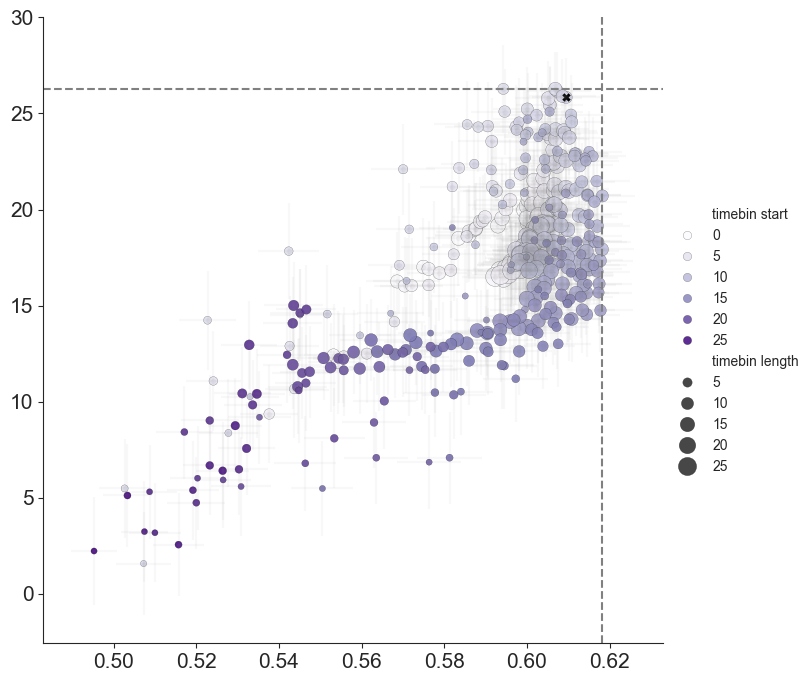

In [332]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.set_style('ticks') 
#sns.set_theme(style="white")
bin_7_17=df_full[(df_full['timebin start']==7)&(df_full['timebin length']==10)]

y='esv corrected'
x='acc'
ax = sns.relplot(data=df_full, y=y, x=x, alpha=0.9,hue='timebin start',palette="Purples"
                 ,size='timebin length',edgecolor='k', linewidth=0.14,
            sizes=(20, 200), height=7)
plt.scatter(x=bin_7_17[x],y=bin_7_17[y],marker='X', linewidths=0.05, c='k', edgecolor='k')
plt.errorbar(df_full[x], df_full[y],fmt=".", alpha=0.05, c='gray',xerr = df_full[f'std {x}'], yerr = df_full[f'esv std']/np.sqrt(10) )
ax.ax.axvline(x=df_full.sort_values(x, ascending=False).iloc[0][x], color='gray', linestyle='dashed')
ax.ax.axhline(y=df_full.sort_values(y, ascending=False).iloc[0][y], color='gray',linestyle='dashed')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('')
#plt.ylabel('Residual reliability ')
plt.xlabel('')
#plt.title('Residual reliability (self-consistency residual monkey)*(self-consistency residual humans) \n correction for partial correlation')
plt.savefig(f'acc_vs_shared_EV_all_bins_non_corrected.pdf', format='pdf')
#plt.ylim(None, 35)


In [61]:
reliabilities = pd.read_pickle('results/600_shc_all_bins.pkl')
pd.DataFrame(reliabilities, index=['shc']).T

shc
0  1 -0.017954
   2 -0.023248
   3 -0.056589
   4 -0.061610
   5 -0.067981
...        ...
26 2  0.184795
   3  0.182700
27 1  0.114812
   2  0.137451
28 1  0.090049

[435 rows x 1 columns]